<a href="https://colab.research.google.com/github/Abhitipu/Abhitipu/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pytorch-lightning
!pip install datasets
!pip install transformers
!pip install tqdm

In [ ]:
from datasets import load_dataset
dataset = load_dataset("banking77")

Using custom data configuration default


Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /root/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_data = dataset['train']
test_data = dataset['test']

print(f"Training data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 10003
Test data size: 3080


In [ ]:
import numpy as np
import torch
from tqdm import tqdm

Frequency of the 77 labels
35


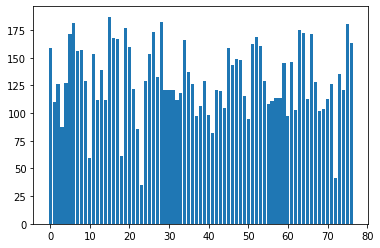

In [ ]:
import matplotlib.pyplot as plt

print('Frequency of the 77 labels')
fig = plt.bar(np.arange(77), np.bincount(train_data['label']))

MAX_TRAIN_INSTANCES = np.min(np.bincount(train_data['label']))
print(MAX_TRAIN_INSTANCES)

In [ ]:
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, AutoModelForCausalLM, AutoTokenizer 

In [ ]:
def gen_random_examples(data, labels, n_classes, n_instances):
  '''
    Generates random examples from a dataset 
    n_instances per class for n_classes
    Outputs are plain text now with integer labels
  '''
  assert(n_classes * n_instances <= len(data))

  freq = np.zeros(n_classes)
  complete = 0
  new_data = []
  new_labels = np.zeros(n_classes * n_instances, dtype=np.int32)
  idx = 0
  
  # Randomization
  perm = np.random.permutation(len(labels))
  labels = labels[perm]
  data = [data[i] for i in perm]

  for text, label in zip(data, labels):
    if complete == n_classes:
      break
    if freq[label] < n_instances:
      freq[label] += 1
      complete += (1 if freq[label] == n_instances else 0)
      new_data.append(text)
      new_labels[idx] = label
      idx += 1
    
  return (new_data, new_labels)
  

In [ ]:
class BERT_LM:
  def __init__(self, model_name):
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.model = BertModel.from_pretrained('bert-base-uncased')
  
  def encode(self, text):
    input_ids = torch.tensor(self.tokenizer.encode(text)).unsqueeze(0)
    outputs = self.model(input_ids)
    # using cls_embedding
    last_hidden_states = outputs[0][:,0].detach().numpy().reshape(-1)
    return last_hidden_states

  def get_encodings(self, data):
    encoded_data = np.array([self.encode(text) for text in data])
    return encoded_data

In [ ]:
class RoBERTa_LM:
  def __init__(self, model_name):
    self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    self.model = RobertaModel.from_pretrained("roberta-base")
  
  def encode(self, text):
    input_ids = torch.tensor(self.tokenizer.encode(text)).unsqueeze(0)
    outputs = self.model(input_ids)
    # using cls_embedding
    last_hidden_states = outputs[0][:,0].detach().numpy().reshape(-1)
    return last_hidden_states

  def get_encodings(self, data):
    encoded_data = np.array([self.encode(text) for text in data])
    return encoded_data

In [ ]:
class DialoGPT_LM:
  def __init__(self, model_name):
    self.tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
    self.model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")
  
  def encode(self, text):
    input_ids = torch.tensor(self.tokenizer.encode(text)).unsqueeze(0)
    outputs = self.model(input_ids)
    # using last token
    last_hidden_states = outputs.logits[0][-1].detach().numpy().reshape(-1)
    return last_hidden_states

  def get_encodings(self, data):
    encoded_data = np.array([self.encode(text) for text in data])
    return encoded_data

In [ ]:
class DialoRPT_LM:
  def __init__(self, model_name):
    self.tokenizer = AutoTokenizer.from_pretrained("microsoft/DialogRPT-human-vs-rand")
    self.model = AutoModelForCausalLM.from_pretrained("microsoft/DialogRPT-human-vs-rand")
  
  def encode(self, text):
    C = torch.tensor(self.tokenizer.encode(text)).unsqueeze(0)
    C1 = self.model.transformer(
              input_ids = C, 
              attention_mask = (C!=self.tokenizer.pad_token_id),
              return_dict=True,
              # output_hidden_states=True
          )
    H = C1.last_hidden_state
    sequence_lengths = torch.ne(C, self.tokenizer.pad_token_id).sum(-1) - 1
    c = H[range(len(C)), sequence_lengths]

    return c.detach().reshape(-1).numpy()

  def get_encodings(self, data):
    encoded_data = np.array([self.encode(text) for text in tqdm(data)])
    return encoded_data

In [ ]:
# Distance functions
def cosine_similarity(X, Y):
    cos_theta = np.dot(X, Y) / (np.linalg.norm(X) * np.linalg.norm(Y) + 1e-35)
    return 1 - cos_theta
  
def euclidian_distance(X, Y):
    ans = np.square(X - Y)
    return np.sqrt(np.sum(ans))

In [ ]:
class KNN:
  '''
    Implementation of a modified version of weighted KNN algorithm.
    The class labels are given so we dont need to compute centers
  '''
  def __init__(self, n_classes, class_instances, points, labels, distance_function):
    assert(n_classes * class_instances == points.shape[0])
    self.n_classes = n_classes
    self.K = class_instances
    self.points = points
    self.labels = labels
    self.distance_function = distance_function

  def predict(self, test_point):
    '''
      Predict the corresponding class of the self.K closest points
    '''
    total_pts = self.points.shape[0]
    distances = np.array([self.distance_function(test_point, point) for point in self.points])
    indices = self.labels

    sorted_indices = distances.argsort()
    distances = distances[sorted_indices[:self.K]]
    labels = indices[sorted_indices[:self.K]] 
    contributions = np.zeros(self.n_classes)

    for label, distance in zip(labels, distances):
      contributions[label] += 1 / (distance * distance + 1e-15)
    
    # predict the one with max weight
    return np.argmax(contributions[:])


In [ ]:
train_labels = np.array([data['label'] for data in train_data], dtype=np.int32)
test_labels = np.array([data['label'] for data in test_data], dtype=np.int32)

N_ITERS = 5
N_CLASSES = 77
n_shots = [1, 4, 7, 10]

In [ ]:
Bert_LM = BERT_LM('bert-base-uncased')
accuracy_values = []

# Generate encodings for test set initially
new_test_data, new_test_labels = test_data['text'], test_labels 
encoded_test_data = Bert_LM.get_encodings(new_test_data)

for dist_fn in [cosine_similarity, euclidian_distance]:
  for N_INSTANCES in n_shots:
    accuracies = []
    for i in range(N_ITERS):

      # Generate encodings for randomly sampled data from training set 
      init_data, init_labels = gen_random_examples(train_data['text'], train_labels, N_CLASSES, N_INSTANCES)
      encoded_init_data = Bert_LM.get_encodings(init_data)

      # Initialize the classifier with the sampled training data
      my_knn_classifier = KNN(N_CLASSES, N_INSTANCES, encoded_init_data, init_labels, dist_fn)
      
      # Predict on encoded test data
      num, den = 0, 0
      for text, label in zip(encoded_test_data, new_test_labels):
        den += 1
        pred = my_knn_classifier.predict(text)
        if pred == label:
          num += 1

      accuracies.append(num/den)  
    avg_acc = sum(accuracies) / N_ITERS
    accuracy_values.append(avg_acc)
    print(f"Avg accuracy for {N_INSTANCES} nearest neighbors using {dist_fn.__name__} is {avg_acc}")
    print(f"Accuracy values are: {accuracies}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Avg accuracy for 1 nearest neighbors using cosine_similarity is 0.11727272727272726
Accuracy values are: [0.12402597402597403, 0.11396103896103896, 0.12435064935064935, 0.11785714285714285, 0.10616883116883116]
Avg accuracy for 4 nearest neighbors using cosine_similarity is 0.2203246753246753
Accuracy values are: [0.21428571428571427, 0.24155844155844156, 0.21266233766233766, 0.21266233766233766, 0.22045454545454546]
Avg accuracy for 7 nearest neighbors using cosine_similarity is 0.28136363636363637
Accuracy values are: [0.2827922077922078, 0.2837662337662338, 0.28214285714285714, 0.2668831168831169, 0.29123376623376623]
Avg accuracy for 10 nearest neighbors using cosine_similarity is 0.33006493506493506
Accuracy values are: [0.3405844155844156, 0.3383116883116883, 0.33311688311688314, 0.31233766233766236, 0.32597402597402597]
Avg accuracy for 1 nearest neighbors using euclidian_distance is 0.12064935064935065
Accuracy values are: [0.10097402597402598, 0.11948051948051948, 0.1243506493

In [ ]:
Roberta_LM = RoBERTa_LM('roberta-base')
accuracy_values2 = []

# Generate encodings for test set
new_test_data, new_test_labels = test_data['text'], test_labels
encoded_test_data = Roberta_LM.get_encodings(new_test_data)

for dist_fn in [cosine_similarity, euclidian_distance]:
  for N_INSTANCES in n_shots:
    accuracies = []
    for i in range(N_ITERS):

      # Generate encodings for randomly sampled data from training set 
      init_data, init_labels = gen_random_examples(train_data['text'], train_labels, N_CLASSES, N_INSTANCES)
      encoded_init_data = Roberta_LM.get_encodings(init_data)

      # new_test_data, new_test_labels = gen_random_examples(test_data['text'], test_labels, N_CLASSES, N_INSTANCES)

      # Initialize the classifier with the sampled training data
      my_knn_classifier = KNN(N_CLASSES, N_INSTANCES, encoded_init_data, init_labels, dist_fn)
      
      # Predict on encoded test data
      num, den = 0, 0
      for text, label in zip(encoded_test_data, new_test_labels):
        den += 1
        pred = my_knn_classifier.predict(text)
        if pred == label:
          num += 1

      accuracies.append(num/den)  
    avg_acc = sum(accuracies) / N_ITERS
    accuracy_values2.append(avg_acc)
    print(f"Avg accuracy for {N_INSTANCES} nearest neighbors using {dist_fn.__name__} is {avg_acc}")
    print(f"Accuracy values are: {accuracies}")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Avg accuracy for 1 nearest neighbors using cosine_similarity is 0.15077922077922076
Accuracy values are: [0.1409090909090909, 0.15162337662337663, 0.16688311688311688, 0.1487012987012987, 0.1457792207792208]
Avg accuracy for 4 nearest neighbors using cosine_similarity is 0.3074675324675325
Accuracy values are: [0.3038961038961039, 0.31753246753246755, 0.3207792207792208, 0.287012987012987, 0.3081168831168831]
Avg accuracy for 7 nearest neighbors using cosine_similarity is 0.3757142857142857
Accuracy values are: [0.35844155844155845, 0.37922077922077924, 0.3938311688311688, 0.38181818181818183, 0.3652597402597403]
Avg accuracy for 10 nearest neighbors using cosine_similarity is 0.42707792207792206
Accuracy values are: [0.42435064935064937, 0.41948051948051945, 0.4266233766233766, 0.43993506493506496, 0.425]
Avg accuracy for 1 nearest neighbors using euclidian_distance is 0.148961038961039
Accuracy values are: [0.15487012987012988, 0.1305194805194805, 0.1474025974025974, 0.15941558441558

In [ ]:
'''
bert= [0.11727272727272726, 0.2203246753246753, 0.28136363636363637, 0.33006493506493506, 0.12064935064935065, 0.21688311688311684, 0.27214285714285713, 0.31292207792207793]
roberta = [0.15077922077922076, 0.3074675324675325, 0.3757142857142857, 0.42707792207792206, 0.148961038961039, 0.28363636363636363, 0.3576623376623377, 0.38857142857142857]
dialogpt 2 = [0.13798701298701296, 0.25857142857142856, 0.30857142857142855, 0.3462337662337663, 0.03032467532467532, 0.04798701298701299, 0.06233766233766234, 0.07006493506493505] 
dialogpt 3 = [0.04662337662337662, 0.07707792207792208, 0.1046103896103896, 0.1324025974025974, 0.04071428571428572, 0.07246753246753247, 0.08753246753246753, 0.1062987012987013]
dialorpt = [0.25142857142857145, 0.413051948051948, 0.4996753246753247, 0.5440909090909092, 0.25422077922077924, 0.4075324675324675, 0.48311688311688306, 0.5177272727272726]
'''

In [ ]:
Dialogpt_LM = DialoGPT_LM('microsoft/DialoGPT-small')
accuracy_values3 = []

# Generate encodings for test set
new_test_data, new_test_labels = test_data['text'], test_labels
encoded_test_data = Dialogpt_LM.get_encodings(new_test_data)

for dist_fn in [cosine_similarity, euclidian_distance]:
  for N_INSTANCES in n_shots:
    accuracies = []
    for i in range(N_ITERS):

      # Generate encodings for randomly sampled data from training set 
      init_data, init_labels = gen_random_examples(train_data['text'], train_labels, N_CLASSES, N_INSTANCES)
      encoded_init_data = Dialogpt_LM.get_encodings(init_data)


      # Initialize the classifier with the sampled training data
      my_knn_classifier = KNN(N_CLASSES, N_INSTANCES, encoded_init_data, init_labels, dist_fn)
      
      # Predict on encoded test data
      num, den = 0, 0
      for text, label in zip(encoded_test_data, new_test_labels):
        den += 1
        pred = my_knn_classifier.predict(text)
        if pred == label:
          num += 1

      accuracies.append(num/den)  
    avg_acc = sum(accuracies) / N_ITERS
    accuracy_values3.append(avg_acc)
    print(f"Avg accuracy for {N_INSTANCES} nearest neighbors using {dist_fn.__name__} is {avg_acc}")
    print(f"Accuracy values are: {accuracies}")

In [ ]:
Dialorpt_LM = DialoRPT_LM("microsoft/DialogRPT-human-vs-rand")
accuracy_values4 = []

# Generate encodings for test set
new_test_data, new_test_labels = test_data['text'], test_labels
encoded_test_data = Dialorpt_LM.get_encodings(new_test_data)

for dist_fn in [cosine_similarity, euclidian_distance]:
  for N_INSTANCES in n_shots:
    accuracies = []
    for i in range(N_ITERS):

      # Generate encodings for randomly sampled data from training set 
      init_data, init_labels = gen_random_examples(train_data['text'], train_labels, N_CLASSES, N_INSTANCES)
      encoded_init_data = Dialorpt_LM.get_encodings(init_data)


      # Initialize the classifier with the sampled training data
      my_knn_classifier = KNN(N_CLASSES, N_INSTANCES, encoded_init_data, init_labels, dist_fn)
      
      # Predict on encoded test data
      num, den = 0, 0
      for text, label in zip(encoded_test_data, new_test_labels):
        den += 1
        pred = my_knn_classifier.predict(text)
        if pred == label:
          num += 1

      accuracies.append(num/den)  
    avg_acc = sum(accuracies) / N_ITERS
    accuracy_values4.append(avg_acc)
    print(f"Avg accuracy for {N_INSTANCES} nearest neighbors using {dist_fn.__name__} is {avg_acc}")
    print(f"Accuracy values are: {accuracies}")

In [ ]:
accuracy_values4 = [0.25142857142857145, 0.413051948051948, 0.4996753246753247, 0.5440909090909092, 0.25422077922077924, 0.4075324675324675, 0.48311688311688306]

In [ ]:
Dialorpt_LM = DialoRPT_LM("microsoft/DialogRPT-human-vs-rand")

# Generate encodings for test set
new_test_data, new_test_labels = test_data['text'], test_labels
encoded_test_data = Dialorpt_LM.get_encodings(new_test_data)

for dist_fn in [euclidian_distance]:
  for N_INSTANCES in [10]:
    accuracies = []
    for i in range(N_ITERS):

      # Generate encodings for randomly sampled data from training set 
      init_data, init_labels = gen_random_examples(train_data['text'], train_labels, N_CLASSES, N_INSTANCES)
      encoded_init_data = Dialorpt_LM.get_encodings(init_data)


      # Initialize the classifier with the sampled training data
      my_knn_classifier = KNN(N_CLASSES, N_INSTANCES, encoded_init_data, init_labels, dist_fn)
      
      # Predict on encoded test data
      num, den = 0, 0
      for text, label in zip(encoded_test_data, new_test_labels):
        den += 1
        pred = my_knn_classifier.predict(text)
        if pred == label:
          num += 1

      accuracies.append(num/den)  
    avg_acc = sum(accuracies) / N_ITERS
    accuracy_values4.append(avg_acc)
    print(f"Avg accuracy for {N_INSTANCES} nearest neighbors using {dist_fn.__name__} is {avg_acc}")
    print(f"Accuracy values are: {accuracies}")

Downloading:   0%|          | 0.00/812 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/DialogRPT-human-vs-rand were not used when initializing GPT2LMHeadModel: ['score.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 770/770 [05:25<00:00,  2.37it/s]


Avg accuracy for 10 nearest neighbors using euclidian_distance is 0.5177272727272726
Accuracy values are: [0.5178571428571429, 0.5172077922077922, 0.5045454545454545, 0.5262987012987013, 0.5227272727272727]


In [1]:
# Final accuracy values
accuracy_values = [0.11727272727272726, 0.2203246753246753, 0.28136363636363637, 0.33006493506493506, 0.12064935064935065, 0.21688311688311684, 0.27214285714285713, 0.31292207792207793]
accuracy_values2 = [0.15077922077922076, 0.3074675324675325, 0.3757142857142857, 0.42707792207792206, 0.148961038961039, 0.28363636363636363, 0.3576623376623377, 0.38857142857142857]
accuracy_values3 = [0.04662337662337662, 0.07707792207792208, 0.1046103896103896, 0.1324025974025974, 0.04071428571428572, 0.07246753246753247, 0.08753246753246753, 0.1062987012987013]  
accuracy_values4 = [0.25142857142857145, 0.413051948051948, 0.4996753246753247, 0.5440909090909092, 0.25422077922077924, 0.4075324675324675, 0.48311688311688306, 0.5177272727272726]
accuracy_values5 = [0.0275974025974026, 0.043701298701298706, 0.0609090909090909, 0.06474025974025974, 0.03493506493506493, 0.06071428571428571, 0.0785064935064935, 0.08733766233766234]

In [2]:
from google.colab import drive, files
# drive.mount('/content/drive')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

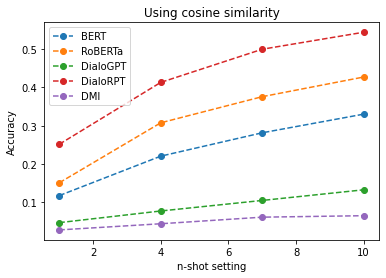

In [3]:
# print(accuracy_values)
# print(accuracy_values2)
# print(accuracy_values3)
import matplotlib.pyplot as plt
n_shots = [1, 4, 7, 10]
plt.title("Using cosine similarity")
plt.xlabel("n-shot setting")
plt.ylabel("Accuracy")

plt.plot(n_shots, accuracy_values[:len(n_shots)], linestyle='--', marker='o', label="BERT")
plt.plot(n_shots, accuracy_values2[:len(n_shots)], linestyle='--', marker='o', label="RoBERTa")
plt.plot(n_shots, accuracy_values3[:len(n_shots)], linestyle='--', marker='o', label="DialoGPT")
plt.plot(n_shots, accuracy_values4[:len(n_shots)], linestyle='--', marker='o', label="DialoRPT")
plt.plot(n_shots, accuracy_values5[:len(n_shots)], linestyle='--', marker='o', label="DMI")
plt.legend()
plt.savefig("cosine_sim.png")
files.download("cosine_sim.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

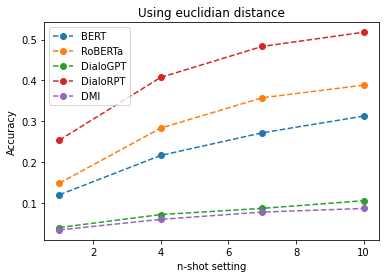

In [4]:
plt.title("Using euclidian distance")
plt.xlabel("n-shot setting")
plt.ylabel("Accuracy")

plt.plot(n_shots, accuracy_values[len(n_shots):], linestyle='--', marker='o', label="BERT")
plt.plot(n_shots, accuracy_values2[len(n_shots):], linestyle='--', marker='o', label="RoBERTa")
plt.plot(n_shots, accuracy_values3[len(n_shots):], linestyle='--', marker='o', label="DialoGPT")
plt.plot(n_shots, accuracy_values4[len(n_shots):], linestyle='--', marker='o', label="DialoRPT")
plt.plot(n_shots, accuracy_values5[len(n_shots):], linestyle='--', marker='o', label="DMI")
plt.legend()
plt.savefig("euc_dist.png")
files.download("euc_dist.png")

In [ ]:
print(accuracy_values4)

[0.25142857142857145, 0.413051948051948, 0.4996753246753247, 0.5440909090909092, 0.25422077922077924, 0.4075324675324675, 0.48311688311688306, 0.5177272727272726]


In [5]:
def get_row(values):
  values = list(map(lambda val: str(round(val, 2)), values))
  print(" & ".join(values), end=" \\\\\n")

In [6]:
# For latex
get_row(accuracy_values)
get_row(accuracy_values2)
get_row(accuracy_values3)
get_row(accuracy_values4)
get_row(accuracy_values5)


0.12 & 0.22 & 0.28 & 0.33 & 0.12 & 0.22 & 0.27 & 0.31 \\
0.15 & 0.31 & 0.38 & 0.43 & 0.15 & 0.28 & 0.36 & 0.39 \\
0.05 & 0.08 & 0.1 & 0.13 & 0.04 & 0.07 & 0.09 & 0.11 \\
0.25 & 0.41 & 0.5 & 0.54 & 0.25 & 0.41 & 0.48 & 0.52 \\
0.03 & 0.04 & 0.06 & 0.06 & 0.03 & 0.06 & 0.08 & 0.09 \\
